In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

plt.rcParams['figure.figsize'] = (12,6)

import pathlib

epoch = np.datetime64('2015-12-31T16:00:00', 'us')

In [2]:
def open_tm(path, sel = slice(None)):
    with open(path) as f:
        tm_lines = f.readlines()[sel]
    tm_t = np.array([epoch + np.timedelta64(int(a.split()[0].lstrip('[').rstrip(']'), 16) * 100, 'us')
            for a in tm_lines])
    tm_x = np.array([[float(x) for x in a.split()[3:]] for a in tm_lines])
    return tm_t, tm_x

In [3]:
tm_sun = open_tm('../../tm_state_vectors/20210207_ATA')
tm_mars = open_tm('../../tm_state_vectors/20210208')

In [4]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

def mjd2datetime64(m):
    return np.datetime64('1970-01-01T00:00:00') + np.timedelta64(1, 'ns') * (mjd2unixtimestamp(m) * 1e9)

In [5]:
def gmat_interp(path, t):
    gmat = np.fromfile(path, sep = ' ').reshape((-1,4))
    gmat_s = (mjd2datetime64(gmat[:,0]) - t[0])/np.timedelta64(1,'s')
    s = (t - t[0])/np.timedelta64(1,'s')
    
    interp = np.empty((t.size, 3))
    for j in range(3):
        interp[:,j] = np.interp(s, gmat_s, gmat[:,1+j], left = np.nan, right = np.nan)
    return interp

def gmat_diff(tm, gmat_path):
    return gmat_interp(gmat_path, tm[0]) - tm[1][:,:3]

In [6]:
def legend():
    plt.legend(['X', 'Y', 'Z'])

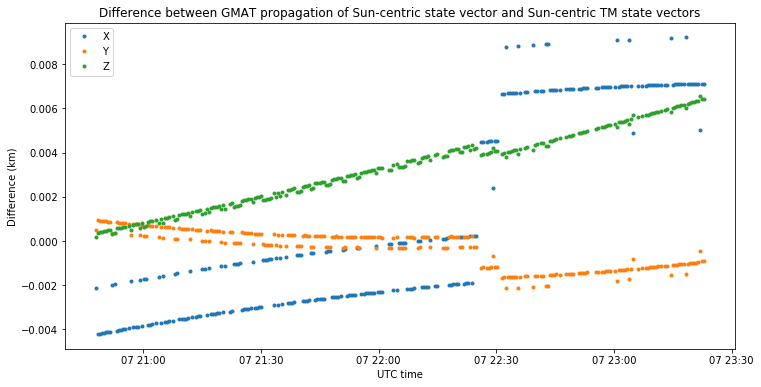

In [7]:
plt.plot(tm_sun[0], gmat_diff(tm_sun, 'Tianwen1_sunsun_XYZ.txt'), '.')
legend()
plt.title('Difference between GMAT propagation of Sun-centric state vector and Sun-centric TM state vectors')
plt.ylabel('Difference (km)')
plt.xlabel('UTC time');

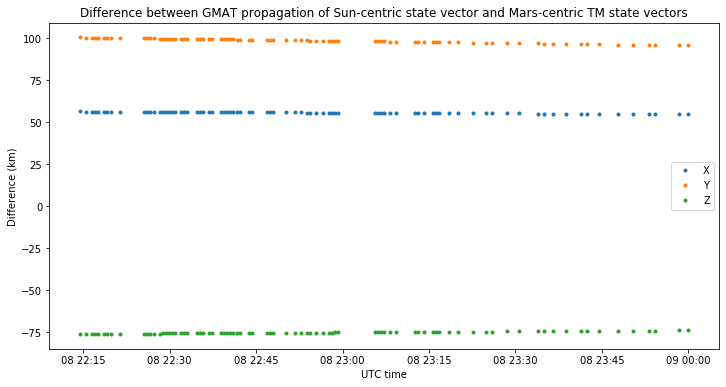

In [8]:
diff = gmat_diff(tm_mars, 'Tianwen1_sunmars_XYZ.txt')
plt.plot(tm_mars[0], diff, '.')
legend()
plt.title('Difference between GMAT propagation of Sun-centric state vector and Mars-centric TM state vectors')
plt.ylabel('Difference (km)')
plt.xlabel('UTC time');

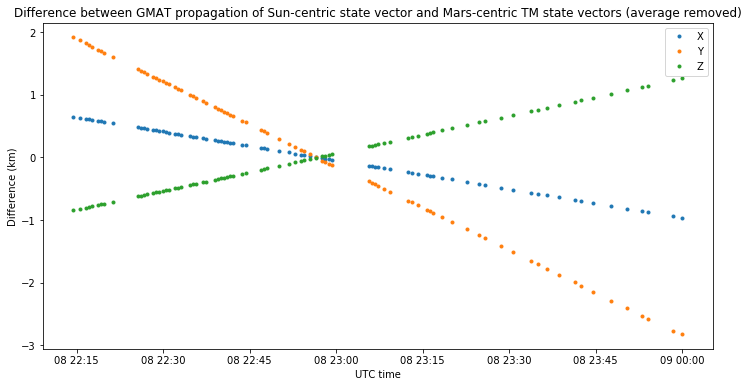

In [9]:
avg_diff = np.average(diff, axis = 0)
plt.plot(tm_mars[0], diff - avg_diff, '.')
legend()
plt.title('Difference between GMAT propagation of Sun-centric state vector and Mars-centric TM state vectors (average removed)')
plt.ylabel('Difference (km)')
plt.xlabel('UTC time');

In [10]:
diff_abs = np.sqrt(np.sum(avg_diff**2))
diff_abs

136.0079528755157

In [11]:
(15*u.mas/u.rad).to(1) * np.sqrt(np.sum(tm_sun[1][0,:3]**2))

<Quantity 16.92762544>

In [12]:
tm_mars_abs = np.sqrt(np.sum(tm_mars[1][:,:3]**2, axis = 1))
(diff_abs / tm_mars_abs[0] * u.rad).to(u.deg)

<Quantity 0.02160392 deg>

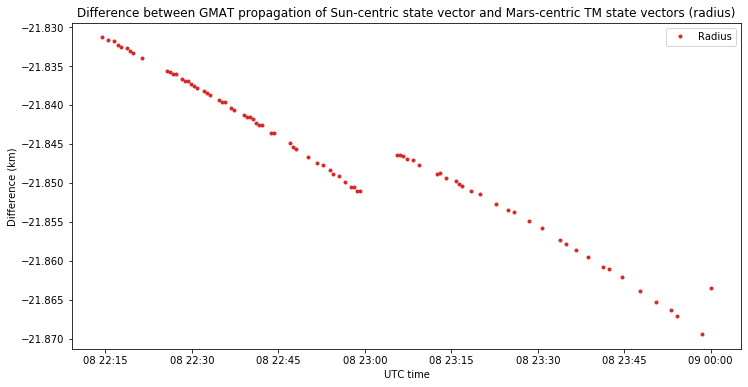

In [13]:
mars_interp = gmat_interp('Tianwen1_sunmars_XYZ.txt', tm_mars[0])
mars_interp_abs = np.sqrt(np.sum(mars_interp**2, axis = 1)) 
plt.plot(tm_mars[0], mars_interp_abs - tm_mars_abs, '.', color = 'C3')
plt.legend(['Radius'])
plt.title('Difference between GMAT propagation of Sun-centric state vector and Mars-centric TM state vectors (radius)')
plt.ylabel('Difference (km)')
plt.xlabel('UTC time');

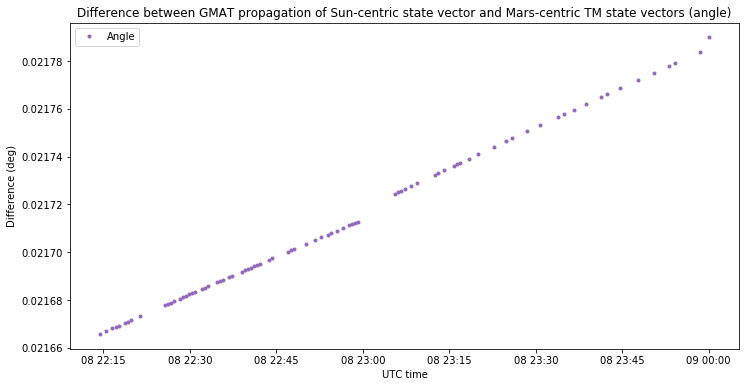

In [14]:
alpha = np.arccos(np.sum(tm_mars[1][:,:3]/tm_mars_abs[:,np.newaxis] \
                         * mars_interp/mars_interp_abs[:,np.newaxis], axis = 1))
plt.plot(tm_mars[0], np.rad2deg(alpha), '.', color = 'C4')
plt.legend(['Angle'])
plt.title('Difference between GMAT propagation of Sun-centric state vector and Mars-centric TM state vectors (angle)')
plt.ylabel('Difference (deg)')
plt.xlabel('UTC time');

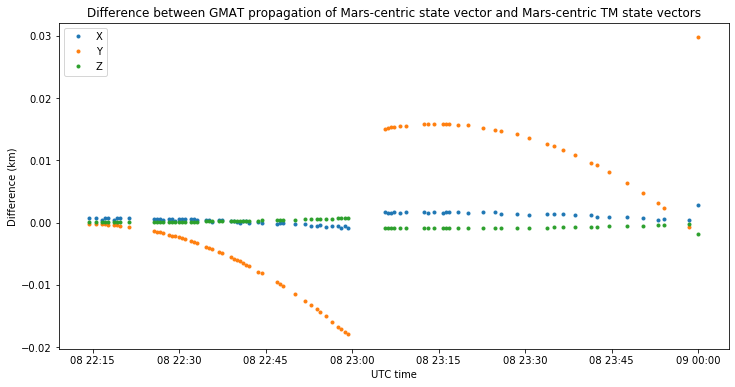

In [15]:
plt.plot(tm_mars[0], gmat_diff(tm_mars, 'Tianwen1_marsmars_XYZ.txt'), '.')
plt.title('Difference between GMAT propagation of Mars-centric state vector and Mars-centric TM state vectors')
legend()
plt.ylabel('Difference (km)')
plt.xlabel('UTC time');